# Data preparation and customer analytics

In [26]:
# Ncessary imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# Data loading
purchase = pd.read_csv('../data/raw/QVI_purchase_behaviour.csv')
transaction = pd.read_excel('../data/raw/QVI_transaction_data.xlsx')

# View the purchase behavior data
purchase.head(3)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget


In [28]:
# View the transaction data
transaction.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [29]:
# Inspecting the data
print(purchase.info())
print('---')
print(transaction.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), obj

In [30]:
# Convert date column to datetime
transaction['DATE'] = pd.to_datetime(transaction['DATE'])

# Extract the pack size and remove it from the product name column
transaction['PROD_NAME'] = transaction['PROD_NAME'].str.replace(r'g$', '', regex=True)
transaction['PACK_SIZE(g)'] = transaction['PROD_NAME'].str.extract(r'(\d+)').astype(int)

# Remove pack size from the product name column
transaction['PROD_NAME'] = transaction['PROD_NAME'].str.replace(r'\d+', '', regex=True)
transaction['PROD_NAME'] = transaction['PROD_NAME'].str.strip()

# Extract the brand name (assuming it is the first word)
transaction['BRAND'] = transaction['PROD_NAME'].str.split().str[0]

# Remove the brand name from the product name column
transaction['PROD_NAME'] = transaction['PROD_NAME'].apply(lambda x: ' '.join(x.split()[1:]))
# transaction['PROD_NAME'] = transaction['PROD_NAME'].str.strip()

# View the new columns 
transaction[['PROD_NAME', 'PACK_SIZE(g)', 'BRAND']].head(3)

,PROD_NAME,PACK_SIZE(g),BRAND
0,Chip Compny SeaSalt,175,Natural
1,Nacho Cheese,175,CCs
2,Crinkle Cut Chips Chicken,170,Smiths


In [31]:
# Merge the datasets
data = pd.merge(transaction, purchase, on = 'LYLTY_CARD_NBR')

# Identify outliers in TOT_SALES and PROD_QTY
q1_sales, q3_sales = np.percentile(data['TOT_SALES'], [25, 75])
iqr_sales = q3_sales - q1_sales
lower_bound_sales = q1_sales - 1.5 * iqr_sales
upper_bound_sales = q3_sales + 1.5 * iqr_sales

# Remove outliers
data = data[(data['TOT_SALES'] >= lower_bound_sales) & (data['TOT_SALES'] <= upper_bound_sales)]

# Confirm if there are any missing values
data.isnull().sum()

# save the merged dataset as csv
folder_path = '../data/processed/'
os.makedirs(folder_path, exist_ok=True)
data.to_csv(f'{folder_path}QVI_merged_data.csv', index=False)

# view the dataset
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE(g),BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1970-01-01 00:00:00.000043390,1,1000,1,5,Chip Compny SeaSalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,1970-01-01 00:00:00.000043599,1,1307,348,66,Nacho Cheese,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,1970-01-01 00:00:00.000043605,1,1343,383,61,Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,1970-01-01 00:00:00.000043330,2,2426,1038,108,Tortilla ChpsHny&Jlpno Chili,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget
5,1970-01-01 00:00:00.000043604,4,4074,2982,57,El Paso Salsa Dip Tomato Mild,1,5.1,300,Old,MIDAGE SINGLES/COUPLES,Budget


                 LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
6           OLDER FAMILIES           Budget  167213.95
19   YOUNG SINGLES/COUPLES       Mainstream  156882.00
13                RETIREES       Mainstream  155033.45
15          YOUNG FAMILIES           Budget  138388.20
9    OLDER SINGLES/COUPLES           Budget  135858.90
10   OLDER SINGLES/COUPLES       Mainstream  132618.30
11   OLDER SINGLES/COUPLES          Premium  131493.95
12                RETIREES           Budget  112415.70
7           OLDER FAMILIES       Mainstream  102668.80
14                RETIREES          Premium   97118.50
16          YOUNG FAMILIES       Mainstream   92154.75
1   MIDAGE SINGLES/COUPLES       Mainstream   90178.20
17          YOUNG FAMILIES          Premium   83553.90
8           OLDER FAMILIES          Premium   80062.50
18   YOUNG SINGLES/COUPLES           Budget   60937.60
2   MIDAGE SINGLES/COUPLES          Premium   58095.55
20   YOUNG SINGLES/COUPLES          Premium   41520.40
0   MIDAGE

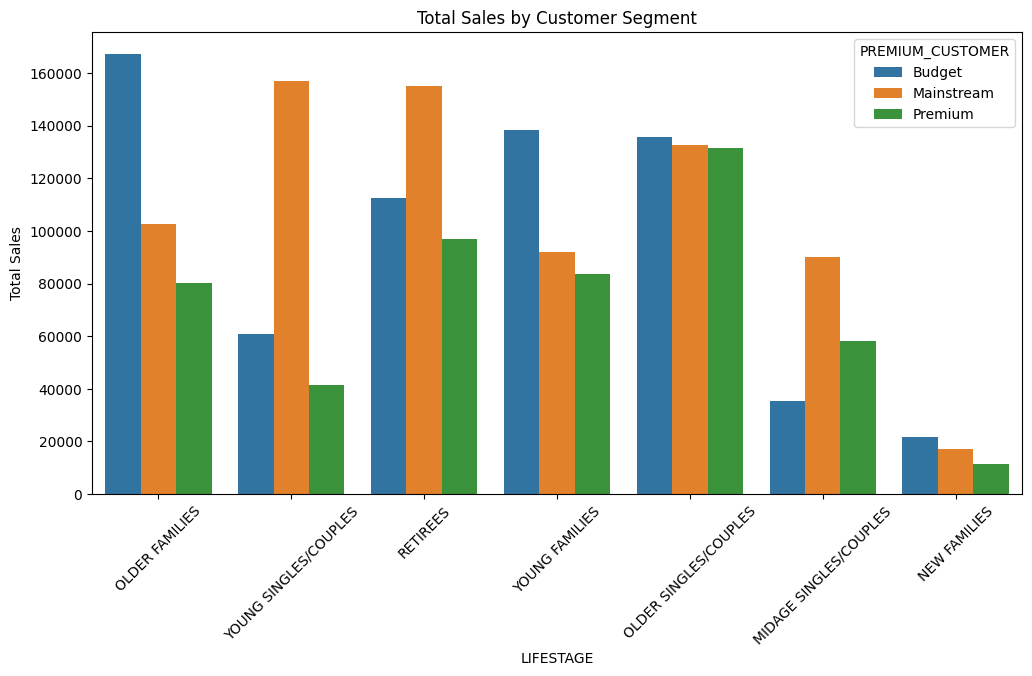

In [32]:
# Image folder for visualization reports
image_folder = '../reports/images/'
os.makedirs(image_folder, exist_ok=True)

# Group by LIFESTAGE and PREMIUM_CUSTOMER, then calculate total sales
segment_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Sort the results for easier visualization
segment_sales = segment_sales.sort_values(by='TOT_SALES', ascending=False)
print(segment_sales)

# Create a bar plot for sales by customer segment
plt.figure(figsize=(12, 6))
sns.barplot(data=segment_sales, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.title('Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.savefig(f'{image_folder}sales_by_customer_segment.png')
plt.show()

        BRAND  TOT_SALES
12     Kettle   387066.2
20     Smiths   209000.7
6     Doritos   200234.2
16   Pringles   176730.5
15        Old    89958.9
23      Thins    88423.5
25   Twisties    80828.4
24   Tostitos    79239.6
10  Infuzions    75863.8
4        Cobs    70148.0


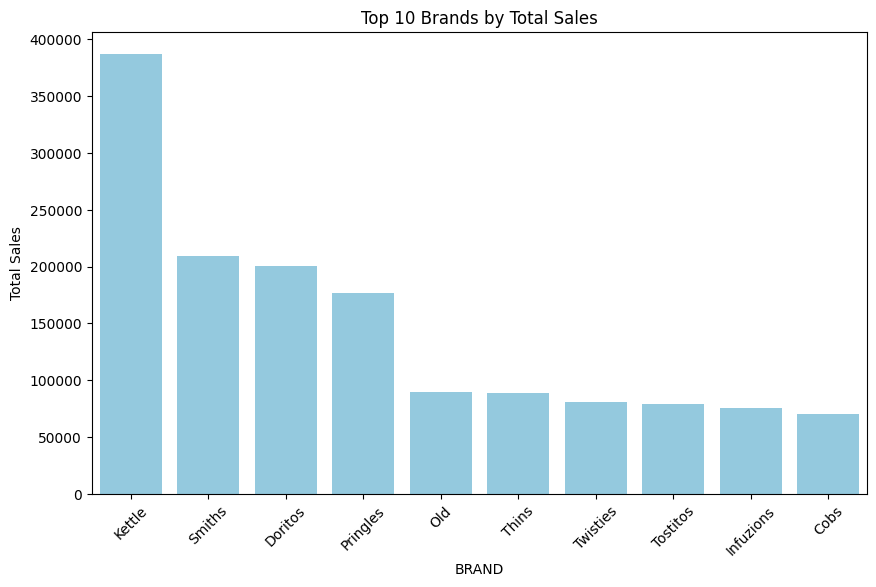

In [33]:
# Calculate total sales by brand
brand_sales = data.groupby('BRAND')['TOT_SALES'].sum().reset_index()

# Sort and view the top 10 brands
top_brands = brand_sales.sort_values(by='TOT_SALES', ascending=False).head(10)
print(top_brands)

# Create a bar plot for top 10 brands
plt.figure(figsize=(10, 6))
sns.barplot(data=top_brands, x='BRAND', y='TOT_SALES', color='skyblue')
plt.title('Top 10 Brands by Total Sales')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.savefig(f'{image_folder}top_brands_by_sales.png')
plt.show()

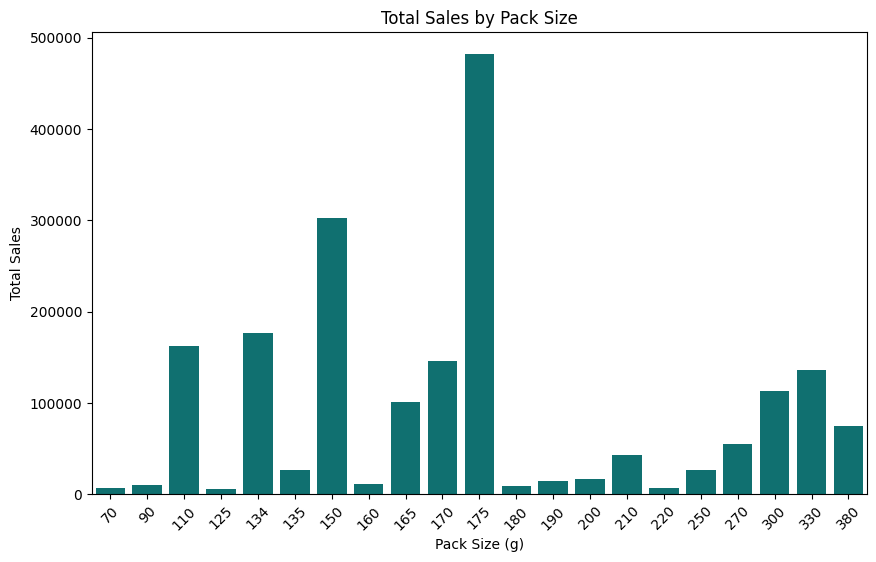

In [36]:
# Analyze the distribution of pack sizes
pack_size_sales = data.groupby('PACK_SIZE(g)')['TOT_SALES'].sum().reset_index()

# Visualize pack size sales
plt.figure(figsize=(10, 6))
sns.barplot(data=pack_size_sales, x='PACK_SIZE(g)', y='TOT_SALES', color='teal')
plt.title('Total Sales by Pack Size')
plt.ylabel('Total Sales')
plt.xlabel('Pack Size (g)')
plt.xticks(rotation=45)
plt.savefig(f'{image_folder}pack__size_sales.png')
plt.show()